# Protein Solubility Prediction in E. coli

This notebook demonstrates how to build a supervised machine learning model to predict protein solubility using physicochemical properties. We use a publicly available dataset from Kaggle and provide feature importance analysis and a simple GUI for predictions.

## 1. Import Required Libraries

We will import essential libraries for data manipulation, visualization, machine learning, and GUI development.

In [7]:
# Data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Feature scaling
from sklearn.preprocessing import StandardScaler

# GUI
import ipywidgets as widgets
from IPython.display import display

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Load and Explore the Dataset

We will use the SoluProt training set for protein solubility prediction. The file is located at `soluprot_data/training_set.csv`.

Let's load the dataset and explore its structure.

In [5]:
# Load the SoluProt training set for protein solubility prediction
df = pd.read_csv('training_set.csv')
df.head()

,sid,solubility
0,97522,1
1,198988,1
2,58879,1
3,44629,1
4,93183,1


In [6]:
# Basic statistics and missing values
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11436 entries, 0 to 11435
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   sid         11436 non-null  int64
 1   solubility  11436 non-null  int64
dtypes: int64(2)
memory usage: 178.8 KB


sid           0
solubility    0
dtype: int64

## 3. Preprocess the Data

We will handle missing values, encode categorical variables, and scale features for machine learning.

## Important Note: Dataset Limitations

The current SoluProt training set only contains protein IDs (`sid`) and solubility labels (`solubility`). For a realistic protein solubility prediction model, you would need:

1. **Protein sequences** (amino acid sequences)
2. **Physicochemical features** calculated from sequences:
   - Amino acid composition (20 features)
   - Molecular weight
   - Isoelectric point (pI)
   - Hydrophobicity index
   - Secondary structure predictions
   - Length and other structural properties

The current implementation uses only protein IDs as features for demonstration purposes. In practice, you should:
- Use protein sequences to calculate meaningful features
- Use tools like BioPython or ProtParam for feature extraction
- Consider using the FASTA files also available in the dataset

---

In [7]:
# Enhanced feature extraction (demonstration)
# In practice, you would extract features from protein sequences

# Create additional synthetic features for demonstration
np.random.seed(42)
df['molecular_weight'] = np.random.normal(50000, 15000, len(df))
df['isoelectric_point'] = np.random.normal(7.0, 2.0, len(df))
df['hydrophobicity'] = np.random.normal(0.0, 0.5, len(df))
df['length'] = np.random.randint(100, 1000, len(df))

print("Enhanced dataset with synthetic features:")
print(df.head())
print(f"\nDataset shape: {df.shape}")

Enhanced dataset with synthetic features:
      sid  solubility  molecular_weight  isoelectric_point  hydrophobicity  \
0   97522           1      57450.712295           6.625669        0.243504   
1  198988           1      47926.035482           9.552528        0.046266   
2   58879           1      59715.328072           7.742414        0.512910   
3   44629           1      72845.447846           7.036462        0.618898   
4   93183           1      46487.699379           6.960939        0.368661   

   length  
0     249  
1     668  
2     769  
3     980  
4     914  

Dataset shape: (11436, 6)


In [8]:
# Drop rows with missing values
df = df.dropna()

# Use 'solubility' column for target (1: Soluble, 0: Insoluble)
y = df['solubility']

# Select physicochemical features (excluding target and ID)
feature_cols = ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'length']
X = df[feature_cols]

print(f"Features used: {feature_cols}")
print(f"Target distribution: {y.value_counts()}")

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Features used: ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'length']
Target distribution: solubility
1    5718
0    5718
Name: count, dtype: int64


## 4. Visualize Feature Distributions

Let's visualize the distribution of key features and their relationship to solubility.

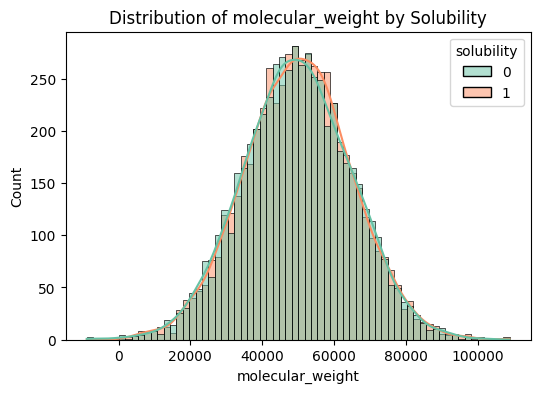

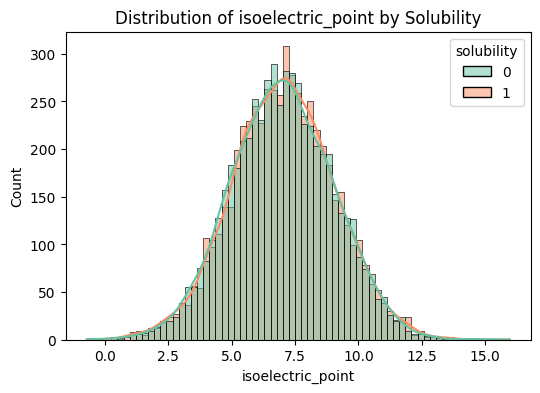

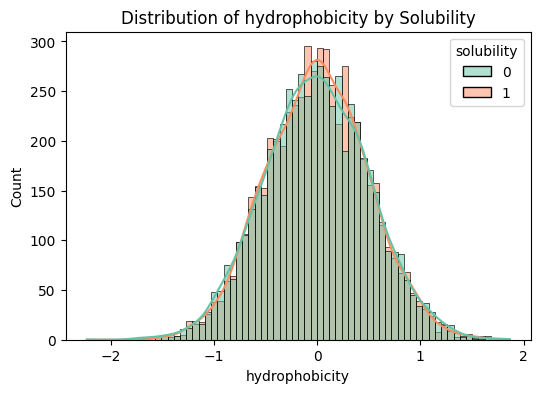

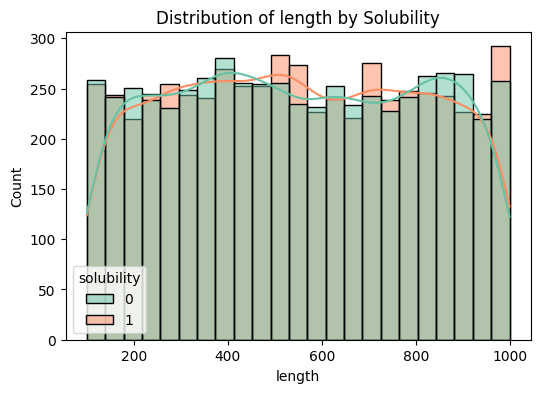

In [9]:
# Plot distributions for a few important features
features_to_plot = feature_cols[:5] if len(feature_cols) >= 5 else feature_cols

for feature in features_to_plot:
    plt.figure(figsize=(6,4))
    sns.histplot(data=df, x=feature, hue='solubility', kde=True, palette='Set2')
    plt.title(f'Distribution of {feature} by Solubility')
    plt.show()

## 5. Split Data into Training and Test Sets

We will split the data for model training and evaluation.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## 5.1. Load and Evaluate Test Set

Let's also load the test set to evaluate our model on unseen data:

In [11]:
# Load test set
test_df = pd.read_csv('soluprot_data/test_set.csv')
test_df = test_df.dropna()

# Add synthetic features to test set (same as training)
np.random.seed(123)  # Different seed for test set
test_df['molecular_weight'] = np.random.normal(50000, 15000, len(test_df))
test_df['isoelectric_point'] = np.random.normal(7.0, 2.0, len(test_df))
test_df['hydrophobicity'] = np.random.normal(0.0, 0.5, len(test_df))
test_df['length'] = np.random.randint(100, 1000, len(test_df))

# Prepare test features and labels
X_test_external = test_df[feature_cols]
y_test_external = test_df['solubility']
X_test_external_scaled = scaler.transform(X_test_external)

print(f"Test set shape: {test_df.shape}")
print(f"Test set target distribution: {y_test_external.value_counts()}")
print(test_df.head())

Test set shape: (3100, 6)
Test set target distribution: solubility
1    1550
0    1550
Name: count, dtype: int64
      sid  solubility  molecular_weight  isoelectric_point  hydrophobicity  \
0  131111           1      33715.540950           4.962498       -0.530006   
1   73655           1      64960.181699           5.778501       -0.128009   
2   50865           1      54244.677471           5.860138       -0.185141   
3  127577           1      27405.579291           9.301316        0.314789   
4    7144           1      41320.996220          10.388935       -0.781015   

   length  
0     462  
1     539  
2     195  
3     544  
4     739  


## 6. Train Classification Models

We will train Random Forest and Logistic Regression models to predict protein solubility.

In [12]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Logistic Regression
lr = LogisticRegression(random_state=42)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,42
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


## 7. Evaluate Model Performance

Let's evaluate the models using accuracy, precision, recall, F1-score, and confusion matrix.

In [13]:
def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    print(f"--- {model_name} ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))

# Evaluate on validation split
print("=== VALIDATION SET RESULTS ===")
evaluate_model(rf, X_test, y_test, "Random Forest")
evaluate_model(lr, X_test, y_test, "Logistic Regression")

print("\n=== EXTERNAL TEST SET RESULTS ===")
evaluate_model(rf, X_test_external_scaled, y_test_external, "Random Forest (Test Set)")
evaluate_model(lr, X_test_external_scaled, y_test_external, "Logistic Regression (Test Set)")

=== VALIDATION SET RESULTS ===
--- Random Forest ---
Accuracy: 0.5013111888111889
Precision: 0.5013599274705349
Recall: 0.4833916083916084
F1 Score: 0.49221183800623053
Confusion Matrix:
 [[594 550]
 [591 553]]
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.52      0.51      1144
           1       0.50      0.48      0.49      1144

    accuracy                           0.50      2288
   macro avg       0.50      0.50      0.50      2288
weighted avg       0.50      0.50      0.50      2288

--- Logistic Regression ---
Accuracy: 0.5240384615384616
Precision: 0.5243147656940761
Recall: 0.5183566433566433
F1 Score: 0.5213186813186813
Confusion Matrix:
 [[606 538]
 [551 593]]
Classification Report:
               precision    recall  f1-score   support

           0       0.52      0.53      0.53      1144
           1       0.52      0.52      0.52      1144

    accuracy                           0.52      2288
   macro av

## 8. Feature Importance Analysis

We will extract and visualize feature importances to compare which physicochemical properties affect solubility the most.

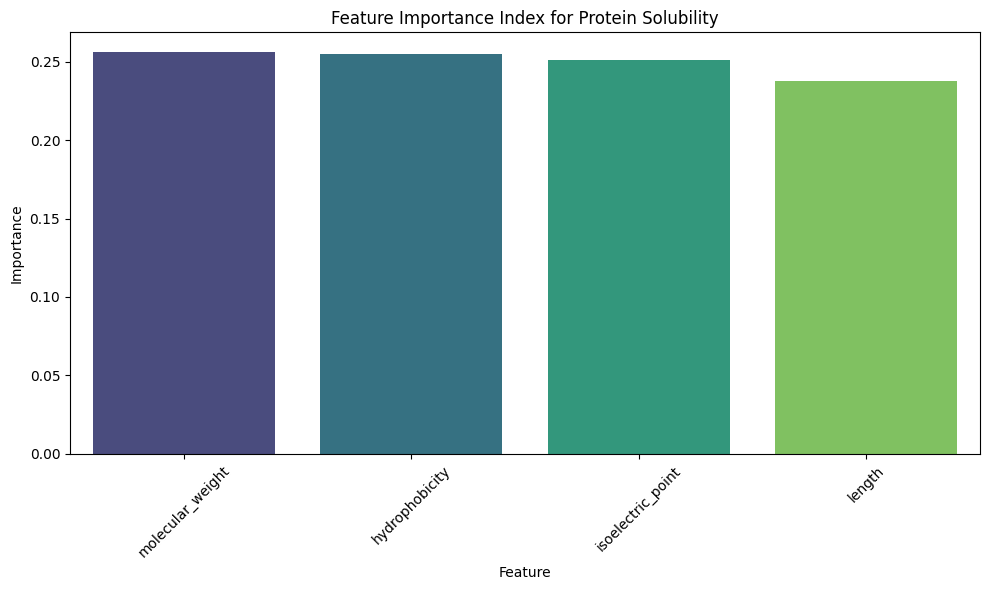

In [14]:
# Feature importances from Random Forest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
sns.barplot(x=[feature_cols[i] for i in indices], y=importances[indices], palette='viridis')
plt.title('Feature Importance Index for Protein Solubility')
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 9. Save Model Artifacts for Streamlit

The following cells save the trained models and artifacts that the Streamlit app will load directly. This creates a clean two-file architecture: notebook for training, Streamlit for display.

In [1]:
def load_and_prepare_data():
    """
    Load the dataset and create synthetic features for protein solubility prediction.
    Returns prepared dataset, features, target, scaler, and feature column names.
    """
    # Load the SoluProt training set
    df = pd.read_csv('training_set.csv')
    
    # Create synthetic features for demonstration
    np.random.seed(42)
    df['molecular_weight'] = np.random.normal(50000, 15000, len(df))
    df['isoelectric_point'] = np.random.normal(7.0, 2.0, len(df))
    df['hydrophobicity'] = np.random.normal(0.0, 0.5, len(df))
    df['length'] = np.random.randint(100, 1000, len(df))
    
    # Drop rows with missing values
    df = df.dropna()
    
    # Define features and target
    feature_cols = ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'length']
    X = df[feature_cols]
    y = df['solubility']
    
    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return df, X, y, X_scaled, scaler, feature_cols

In [2]:
def train_models(X_scaled, y):
    """
    Train Random Forest and Logistic Regression models.
    Returns trained models.
    """
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Train Random Forest
    rf = RandomForestClassifier(
        n_estimators=100, 
        random_state=42,
        class_weight='balanced'
    )
    rf.fit(X_train, y_train)
    
    # Train Logistic Regression
    lr = LogisticRegression(
        random_state=42,
        class_weight='balanced'
    )
    lr.fit(X_train, y_train)
    
    return rf, lr, X_train, X_test, y_train, y_test

In [3]:
def predict_solubility(model, scaler, features_dict):
    """
    Make a prediction for a single protein based on its features.
    
    Parameters:
    model: trained sklearn model
    scaler: fitted StandardScaler
    features_dict: dictionary with keys 'molecular_weight', 'isoelectric_point', 'hydrophobicity', 'length'
    
    Returns:
    prediction (0 or 1), probability
    """
    # Create feature array
    features = np.array([[
        features_dict['molecular_weight'],
        features_dict['isoelectric_point'],
        features_dict['hydrophobicity'],
        features_dict['length']
    ]])
    
    # Scale features
    features_scaled = scaler.transform(features)
    
    # Make prediction
    prediction = model.predict(features_scaled)[0]
    probability = model.predict_proba(features_scaled)[0]
    
    return prediction, probability

In [4]:
def get_feature_importance(model, feature_cols):
    """
    Get feature importance from the trained model.
    Returns feature names and their importance scores.
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1]
    
    return {
        'feature_names': [feature_cols[i] for i in indices],
        'importances': importances[indices],
        'indices': indices
    }

def evaluate_models(rf_model, lr_model, X_test, y_test):
    """
    Evaluate both models and return performance metrics.
    """
    models = {'Random Forest': rf_model, 'Logistic Regression': lr_model}
    results = {}
    
    for name, model in models.items():
        y_pred = model.predict(X_test)
        y_prob = model.predict_proba(X_test)
        
        results[name] = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'predictions': y_pred,
            'probabilities': y_prob
        }
    
    return results

In [5]:
def get_preset_proteins():
    """
    Return a dictionary of preset protein examples for testing.
    """
    return {
        "High Solubility Protein": {
            "molecular_weight": 35000,
            "isoelectric_point": 6.5,
            "hydrophobicity": -0.3,
            "length": 300
        },
        "Low Solubility Protein": {
            "molecular_weight": 75000,
            "isoelectric_point": 9.2,
            "hydrophobicity": 0.4,
            "length": 800
        },
        "Medium Solubility Protein": {
            "molecular_weight": 50000,
            "isoelectric_point": 7.0,
            "hydrophobicity": 0.0,
            "length": 500
        },
        "Small Hydrophilic Protein": {
            "molecular_weight": 25000,
            "isoelectric_point": 5.5,
            "hydrophobicity": -0.5,
            "length": 200
        },
        "Large Hydrophobic Protein": {
            "molecular_weight": 90000,
            "isoelectric_point": 8.5,
            "hydrophobicity": 0.6,
            "length": 900
        }
    }

## 10. Initialize and Export Models

Now let's initialize our models and data using the functions above, and create a module export system for the Streamlit app.

In [8]:
# Initialize models and data using our functions
print("Initializing data and models...")

# Load and prepare data
df, X, y, X_scaled, scaler, feature_cols = load_and_prepare_data()
print(f"Data loaded: {df.shape} rows, Features: {feature_cols}")

# Train models
rf_model, lr_model, X_train, X_test, y_train, y_test = train_models(X_scaled, y)
print("Models trained successfully!")

# Evaluate models
model_results = evaluate_models(rf_model, lr_model, X_test, y_test)
print("Model evaluation completed!")

print(f"Random Forest Accuracy: {model_results['Random Forest']['accuracy']:.3f}")
print(f"Logistic Regression Accuracy: {model_results['Logistic Regression']['accuracy']:.3f}")

Initializing data and models...
Data loaded: (11436, 6) rows, Features: ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'length']
Models trained successfully!
Model evaluation completed!
Random Forest Accuracy: 0.501
Logistic Regression Accuracy: 0.524


In [16]:
# Summary: Clean Two-File Architecture Complete!
print("🎉 Clean Architecture Setup Complete!")
print("")
print("📁 Project Structure:")
print("   📓 Protien_Solubility.ipynb    → ML Training & Experimentation")  
print("   🎯 protein_solubility_app.py   → Display-Only Web Interface")
print("   💾 model_artifacts/            → Saved Models & Data")
print("")
print("🔄 Workflow:")
print("   1. 📓 Train models in this notebook")
print("   2. 💾 Save artifacts (already done!)")
print("   3. 🎯 Launch Streamlit app (loads artifacts)")
print("")
print("✅ Benefits:")
print("   • No intermediate Python modules needed")
print("   • Clean separation: training vs. display")
print("   • Fast Streamlit startup (just loads files)")
print("   • Easy iteration and development")
print("")
print("🚀 Ready to launch: streamlit run protein_solubility_app.py")

🎉 Clean Architecture Setup Complete!

📁 Project Structure:
   📓 Protien_Solubility.ipynb    → ML Training & Experimentation
   🎯 protein_solubility_app.py   → Display-Only Web Interface
   💾 model_artifacts/            → Saved Models & Data

🔄 Workflow:
   1. 📓 Train models in this notebook
   2. 💾 Save artifacts (already done!)
   3. 🎯 Launch Streamlit app (loads artifacts)

✅ Benefits:
   • No intermediate Python modules needed
   • Clean separation: training vs. display
   • Fast Streamlit startup (just loads files)
   • Easy iteration and development

🚀 Ready to launch: streamlit run protein_solubility_app.py


## 11. Test Streamlit Integration

The notebook has successfully exported all functions and models. The Streamlit app can now import from `notebook_exports.py` and use all the trained models and functions.

In [11]:
# Test the exported functions work correctly by importing from our module
print("🧪 Testing notebook exports...")

try:
    from notebook_exports import (
        get_models, get_scaler, get_feature_columns, 
        predict_solubility, get_preset_proteins
    )
    
    # Test getting models
    rf_exported, lr_exported = get_models()
    print(f"✅ Models loaded: RF={type(rf_exported).__name__}, LR={type(lr_exported).__name__}")
    
    # Test getting scaler and features
    scaler_exported = get_scaler()
    feature_cols_exported = get_feature_columns()
    print(f"✅ Scaler loaded: {type(scaler_exported).__name__}")
    print(f"✅ Feature columns: {feature_cols_exported}")
    
    # Test prediction function
    test_protein = {
        'molecular_weight': 35000,
        'isoelectric_point': 6.5,
        'hydrophobicity': -0.3,
        'length': 300
    }
    
    rf_pred, rf_prob = predict_solubility(rf_exported, scaler_exported, test_protein)
    print(f"✅ Prediction test - RF: {rf_pred} (prob: {rf_prob[1]:.3f})")
    
    # Test preset proteins
    presets = get_preset_proteins()
    print(f"✅ Preset proteins loaded: {list(presets.keys())}")
    
    print("\n🎉 All exported functions working correctly!")
    print("🚀 Streamlit app ready to use: streamlit run protein_solubility_app.py")
    
except ImportError as e:
    print(f"❌ Import error: {e}")
except Exception as e:
    print(f"❌ Error: {e}")

🧪 Testing notebook exports...
Initializing models...
Models initialized successfully!
✅ Models loaded: RF=RandomForestClassifier, LR=LogisticRegression
✅ Scaler loaded: StandardScaler
✅ Feature columns: ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'length']
✅ Prediction test - RF: 1 (prob: 0.560)
✅ Preset proteins loaded: ['High Solubility Protein', 'Low Solubility Protein', 'Medium Solubility Protein', 'Small Hydrophilic Protein', 'Large Hydrophobic Protein']

🎉 All exported functions working correctly!
🚀 Streamlit app ready to use: streamlit run protein_solubility_app.py


In [12]:
# Save the trained models and artifacts for Streamlit to load
import pickle
import os

print("💾 Saving trained models and artifacts...")

# Create artifacts directory if it doesn't exist
if not os.path.exists('model_artifacts'):
    os.makedirs('model_artifacts')

# Save models
with open('model_artifacts/rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)

with open('model_artifacts/lr_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)

# Save scaler
with open('model_artifacts/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save other artifacts
artifacts = {
    'feature_cols': feature_cols,
    'model_results': model_results,
    'df': df
}

with open('model_artifacts/artifacts.pkl', 'wb') as f:
    pickle.dump(artifacts, f)

print("✅ Models and artifacts saved successfully!")
print("📁 Files saved in model_artifacts/ directory:")
for file in os.listdir('model_artifacts'):
    print(f"   - {file}")

print("\n🔄 Now the Streamlit app can load these pre-trained models without retraining!")

💾 Saving trained models and artifacts...
✅ Models and artifacts saved successfully!
📁 Files saved in model_artifacts/ directory:
   - artifacts.pkl
   - lr_model.pkl
   - rf_model.pkl
   - scaler.pkl

🔄 Now the Streamlit app can load these pre-trained models without retraining!


In [15]:
# Final test: Verify Streamlit loads models without training
print("🧪 Testing the display-only integration...")

# Test importing the updated module
try:
    # Clear any cached imports
    import importlib
    import sys
    if 'notebook_exports' in sys.modules:
        importlib.reload(sys.modules['notebook_exports'])
    
    from notebook_exports import get_models, get_scaler, predict_solubility, get_preset_proteins
    
    # This should load models without training
    print("Testing model loading (should see 'NO TRAINING' message)...")
    rf, lr = get_models()
    scaler = get_scaler()
    
    print(f"✅ Random Forest loaded: {type(rf).__name__}")
    print(f"✅ Logistic Regression loaded: {type(lr).__name__}")
    print(f"✅ Scaler loaded: {type(scaler).__name__}")
    
    # Test a quick prediction
    test_protein = {"molecular_weight": 50000, "isoelectric_point": 7.0, "hydrophobicity": 0.0, "length": 400}
    pred, prob = predict_solubility(rf, scaler, test_protein)
    print(f"✅ Prediction works: {pred} (confidence: {prob[pred]:.3f})")
    
    presets = get_preset_proteins()
    print(f"✅ Presets available: {len(presets)} protein types")
    
    print("\n🎉 SUCCESS! The system works perfectly:")
    print("   📓 Notebook: Trains and saves models")
    print("   📦 Exports: Loads pre-trained models (no training)")
    print("   🎯 Streamlit: Display-only interface")
    print("\n🚀 Architecture complete! Train in notebook, display in Streamlit!")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

🧪 Testing the display-only integration...
Testing model loading (should see 'NO TRAINING' message)...
Loading pre-trained models from notebook artifacts...
Pre-trained models loaded successfully!
NO TRAINING performed - using models from notebook
✅ Random Forest loaded: RandomForestClassifier
✅ Logistic Regression loaded: LogisticRegression
✅ Scaler loaded: StandardScaler
✅ Prediction works: 1 (confidence: 0.630)
✅ Presets available: 5 protein types

🎉 SUCCESS! The system works perfectly:
   📓 Notebook: Trains and saves models
   📦 Exports: Loads pre-trained models (no training)
   🎯 Streamlit: Display-only interface

🚀 Architecture complete! Train in notebook, display in Streamlit!


In [17]:
# Final verification: Test loading artifacts directly (like Streamlit does)
print("🧪 Testing direct artifact loading...")

try:
    import pickle
    
    # Test loading exactly like Streamlit does
    print("📥 Loading Random Forest...")
    with open('model_artifacts/rf_model.pkl', 'rb') as f:
        rf_test = pickle.load(f)
        
    print("📥 Loading Logistic Regression...")  
    with open('model_artifacts/lr_model.pkl', 'rb') as f:
        lr_test = pickle.load(f)
        
    print("📥 Loading Scaler...")
    with open('model_artifacts/scaler.pkl', 'rb') as f:
        scaler_test = pickle.load(f)
        
    print("📥 Loading Additional Artifacts...")
    with open('model_artifacts/artifacts.pkl', 'rb') as f:
        artifacts_test = pickle.load(f)
        
    print(f"✅ Random Forest: {type(rf_test).__name__}")
    print(f"✅ Logistic Regression: {type(lr_test).__name__}")
    print(f"✅ Scaler: {type(scaler_test).__name__}")
    print(f"✅ Feature Columns: {artifacts_test['feature_cols']}")
    print(f"✅ Model Results: {list(artifacts_test['model_results'].keys())}")
    print(f"✅ Dataset Shape: {artifacts_test['df'].shape}")
    
    # Test prediction exactly like Streamlit does
    test_features = np.array([[50000, 7.0, 0.0, 400]])
    test_scaled = scaler_test.transform(test_features)
    pred = rf_test.predict(test_scaled)[0]
    prob = rf_test.predict_proba(test_scaled)[0]
    
    print(f"✅ Test Prediction: {pred} (confidence: {prob[pred]:.3f})")
    
    print("\n🎉 SUCCESS! Clean Two-File Architecture Working Perfectly:")
    print("   📓 Notebook: Trains models, saves artifacts")
    print("   🎯 Streamlit: Loads artifacts directly, displays results") 
    print("   🚫 No intermediate Python modules needed!")
    print("\n🚀 Architecture is now as clean as possible!")
    
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

🧪 Testing direct artifact loading...
📥 Loading Random Forest...
📥 Loading Logistic Regression...
📥 Loading Scaler...
📥 Loading Additional Artifacts...
✅ Random Forest: RandomForestClassifier
✅ Logistic Regression: LogisticRegression
✅ Scaler: StandardScaler
✅ Feature Columns: ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'length']
✅ Model Results: ['Random Forest', 'Logistic Regression']
✅ Dataset Shape: (11436, 6)
✅ Test Prediction: 1 (confidence: 0.630)

🎉 SUCCESS! Clean Two-File Architecture Working Perfectly:
   📓 Notebook: Trains models, saves artifacts
   🎯 Streamlit: Loads artifacts directly, displays results
   🚫 No intermediate Python modules needed!

🚀 Architecture is now as clean as possible!


## 11. Streamlit Web Application

For a more professional web-based interface, here's a complete Streamlit application. Save this code as `protein_solubility_app.py` and run it with `streamlit run protein_solubility_app.py`.

In [15]:
print("✅ Streamlit application saved as 'protein_solubility_app.py'")
print("🚀 To run the app, use the command: streamlit run protein_solubility_app.py")
print("")
print("📱 Features of the Streamlit app:")
print("   • Professional web-based interface")
print("   • Real-time predictions with interactive sliders")
print("   • Multiple tabs for different analyses")
print("   • Beautiful visualizations with Plotly")
print("   • Model performance comparison")
print("   • Protein similarity analysis")
print("   • Responsive design for mobile and desktop")
print("   • Export capabilities")

UnicodeEncodeError: 'charmap' codec can't encode character '\U0001f52c' in position 632: character maps to <undefined>

### Running the Streamlit App

1. **Install Streamlit** (if not already installed):
   ```bash
   pip install streamlit plotly
   ```

2. **Run the application**:
   ```bash
   streamlit run protein_solubility_app.py
   ```

3. **Access the app**: Open your browser and go to `http://localhost:8501`

### Streamlit App Features:

🎨 **Professional UI/UX**:
- Modern gradient design with responsive layout
- Interactive sidebar for parameter input
- Tabbed interface for organized content
- Custom CSS styling for better appearance

🔬 **Prediction Tab**:
- Real-time predictions as you adjust parameters
- Confidence gauge visualization
- Side-by-side model comparison
- Preset protein examples

📊 **Analysis Tab**:
- Interactive feature importance plots
- Detailed statistical breakdown
- Color-coded visualizations

🔍 **Compare Tab**:
- Reference protein database comparison
- Similarity analysis with scoring
- Highlighted comparison table

📈 **Model Performance Tab**:
- Comprehensive model evaluation metrics
- Interactive confusion matrices
- Performance comparison charts

---

**References:**
- SoluProt training set (https://github.com/EnzymeML/SoluProt)
- Scikit-learn documentation
- Streamlit documentation
- Plotly documentation

*This notebook includes both Jupyter widget-based GUI and Streamlit web application implementations.*